In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/prichter/Documents/selenobot/src/')

# Detection task

"Detection task" refers to the ability of the classifier to identify a sequence as either an erroneously-truncated selenoprotein, or a full-length non-selenoprotein. For this task, we used full-length negative normal proteins as negative test cases. The negative cases did *not* include full-length selenoproteins; we are basing this project on the observation that selenoproteins are misidentified, so full-length selenoproteins will not be present in the data we use to validate the model. The positive cases consisted of selenoproteins truncated at the *first* selenocysteine residue only. 

In [3]:
# Define the data and figure directories. 
DATA_DIR = '/home/prichter/Documents/selenobot/data/uniprot_2023_03/detect' 
FIGURE_DIR = '/home/prichter/Documents/selenobot/figures/'

In [4]:
from src.classifiers import EmbeddingClassifier, AacClassifier, optimize_hyperparameters
from src.dataset import get_dataloader
from src.utils import csv_ids, csv_labels
import src.plot as plot
import src.classifiers as classifiers

import os
import matplotlib.pyplot as plt
import seaborn as sns

/home/prichter/Documents/selenobot/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Paths where the train and test data are stored. 
train_path = os.path.join(DATA_DIR, 'train.csv')
test_path = os.path.join(DATA_DIR, 'test.csv')
val_path = os.path.join(DATA_DIR, 'val.csv')

# First load the data into a dataset object. 
train_dataloader = get_dataloader(train_path, batch_size=1024) #, balance=True)
val_dataloader = get_dataloader(val_path, batch_size=1024)#, balance=True)
test_dataloader = get_dataloader(test_path, batch_size=1024) #, balance=True)

## Testing the benchmark (AacClassifier)

In [6]:
# aac_model = AacClassifier(dropout=0.8)
aac_model = AacClassifier()
aac_train_reporter = aac_model.fit(train_dataloader, val=val_dataloader, bce_loss_weight=1, epochs=3)

classifiers.Classifier.train_: 100%|██████████| 3/3 [00:29<00:00,  9.93s/it, val_acc=0.85]


The training curves for the `AacClassifier` are given below. Interestingly, in the top panel, it seems as though training loss exceeds validation loss. This is likely due to the large imbalance in the validation set, which contains only 6 percent truncated selenoproteins (as compared to the training set, which contains 25.4 percent truncated selenoproteins). This means that the validation set is a comparatively easier problem -- a low loss socre can be obtained by simply classifying everything as full-length. 

This phenomenon might also help explain the strange pattern in the bottom panel. In these cases, balanced accuracy is being calculated, which explains why training accuracy is largely higher than validation accuracy; balanced accuray accounts for class imbalance. 

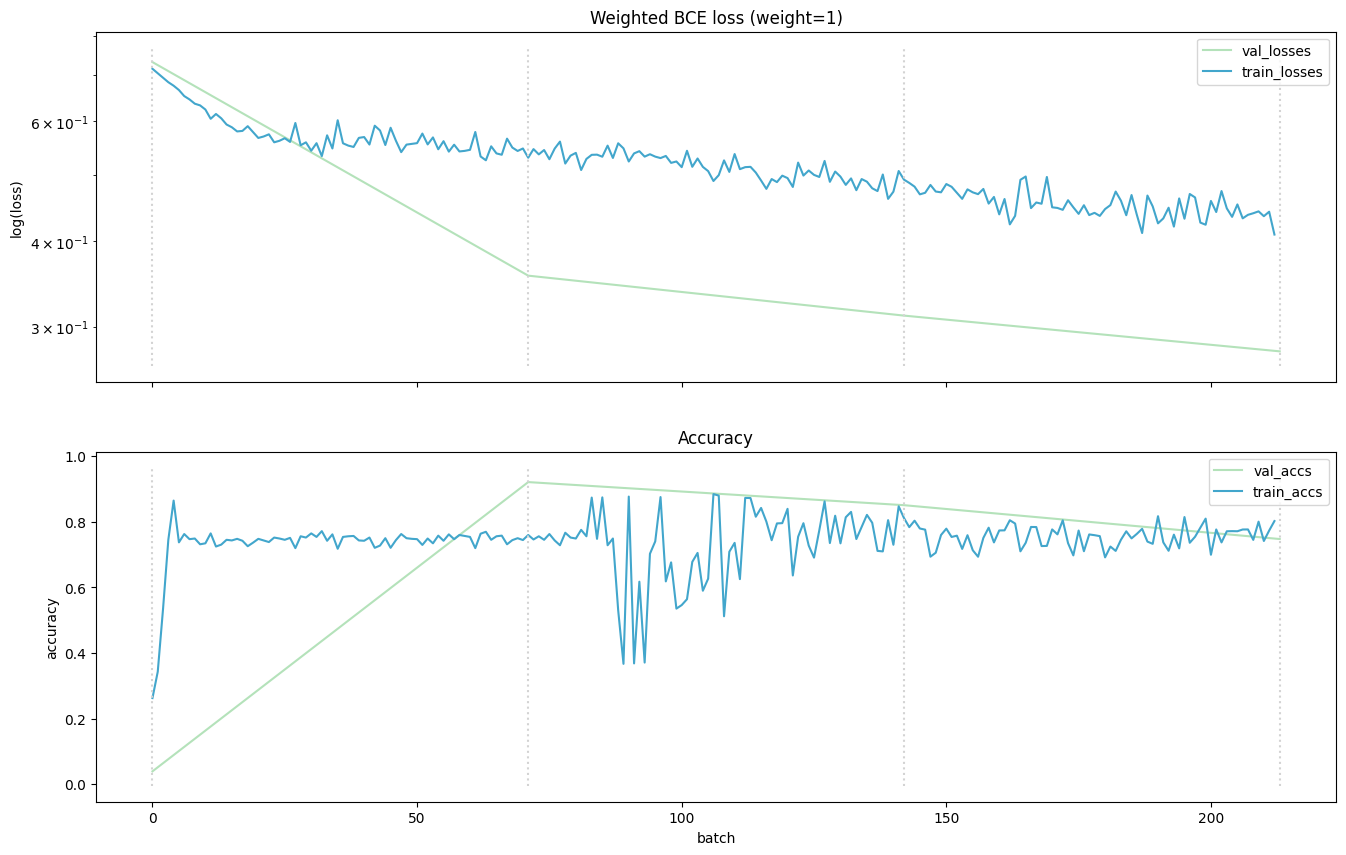

In [7]:
plot.plot_train_reporter(aac_train_reporter, path=None)

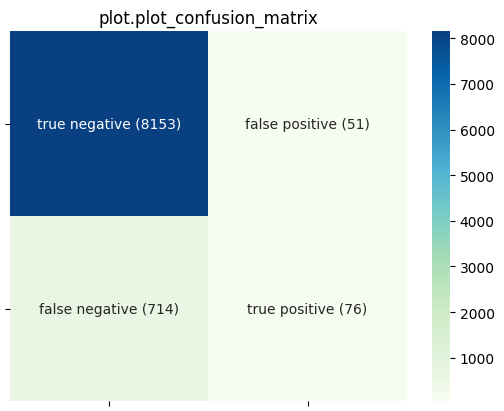

In [8]:
plot.plot_confusion_matrix(aac_model.test(test_dataloader))

In [9]:
thresholds, reporters = classifiers.get_roc_data(aac_model, test_dataloader)

In [10]:
reporters[0].get_confusion_matrix()
# (tn, fp, fn, tp) 

(0, 8204, 0, 790)

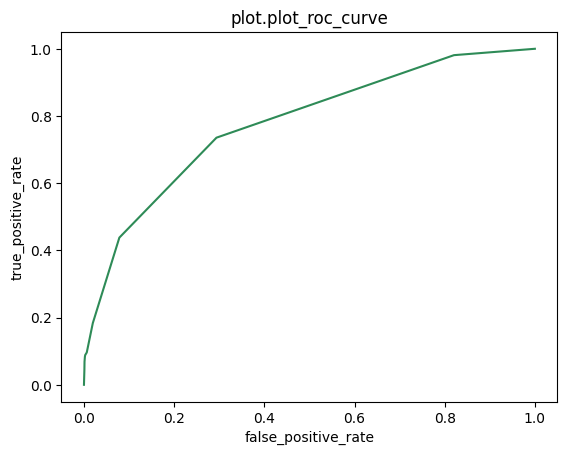

In [11]:
plot.plot_roc_curve(thresholds, reporters)

## Testing the Prot-T5 embeddings (EmbeddingClassifier)

In [12]:
# First, try training with no other weight, to get a sense of how many epochs to use.
emb_model = EmbeddingClassifier(latent_dim=1024) 
emb_train_reporter = emb_model.fit(train_dataloader, val=val_dataloader, bce_loss_weight=1, epochs=3)

classifiers.Classifier.train_: 100%|██████████| 3/3 [00:11<00:00,  3.84s/it, val_acc=0.99]


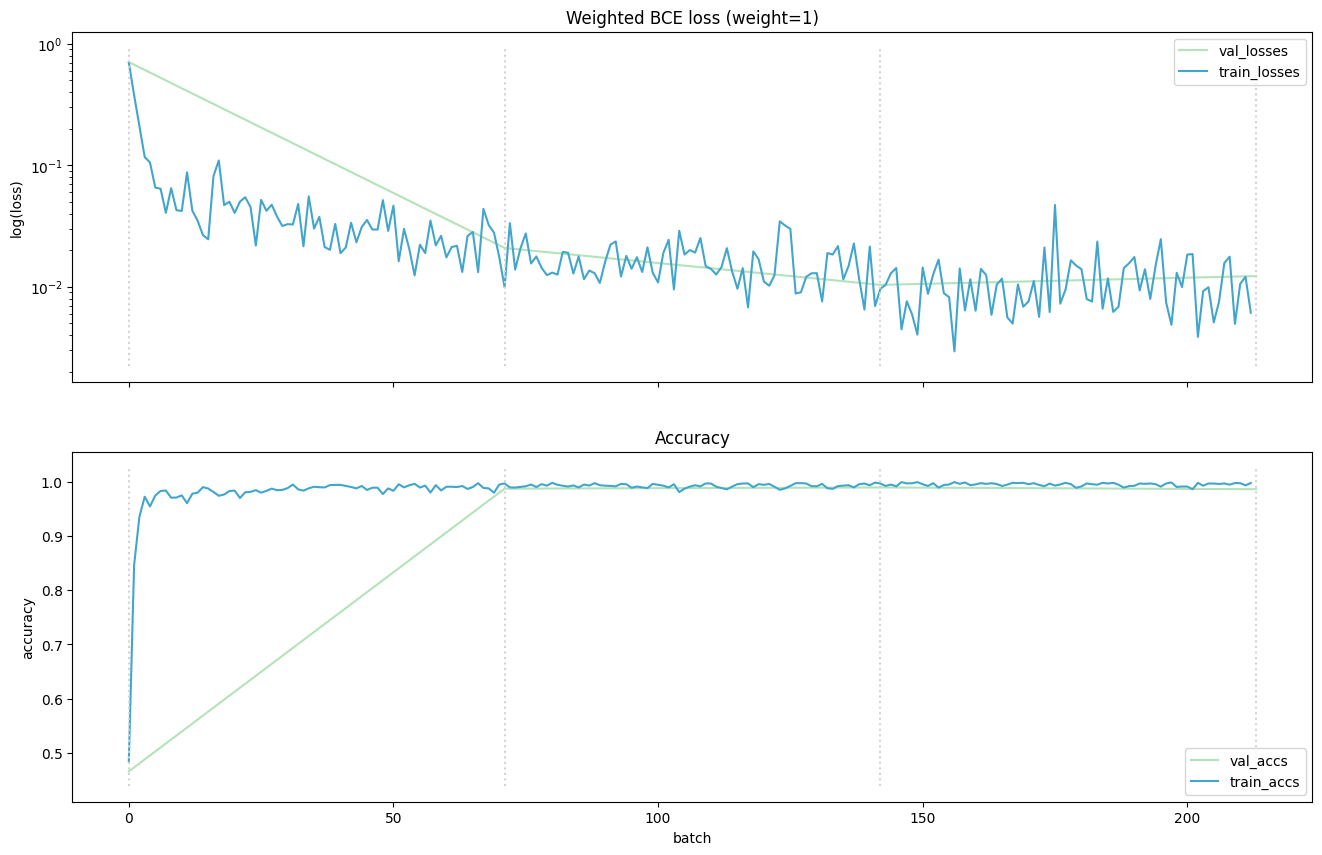

In [13]:
plot.plot_train_reporter(emb_train_reporter, path=None)

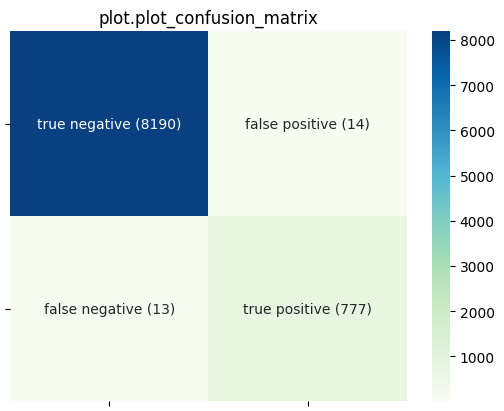

In [14]:
plot.plot_confusion_matrix(emb_model.test(test_dataloader))

In [19]:
thresholds, reporters = classifiers.get_roc_data(emb_model, test_dataloader)

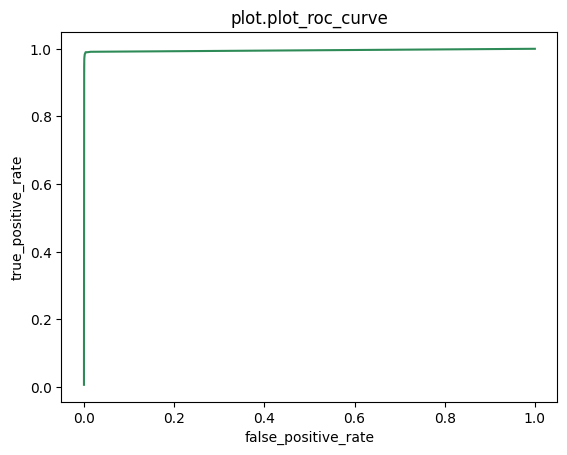

In [20]:
plot.plot_roc_curve(thresholds, reporters) # What is going on here?

## Hyperparameter optimization

I opted to use Bayesian optimization. 

In [ ]:
best = optimize_hyperparameters(train_dataloader, val_dataloader, model=EmbeddingClassifier(), n_calls=50)

classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.98 with bce_loss_weight=6.497832742938128.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.98 with bce_loss_weight=7.377979914165069.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.98 with bce_loss_weight=3.2778845550274536.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.99 with bce_loss_weight=7.349313854777746.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.99 with bce_loss_weight=4.835433389470598.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.98 with bce_loss_weight=6.731919935988591.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.99 with bce_loss_weight=4.953075261536661.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.98 with bce_loss_weight=3.189040093093604.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.99 with bce_loss_weight=6.919467022709755.


In [ ]:
best = optimize_hyperparameters(train_dataloader, val_dataloader, model=AacClassifier(), n_calls=50)

classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.57 with bce_loss_weight=7.552407284238611.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.57 with bce_loss_weight=8.592253510403182.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.58 with bce_loss_weight=7.447397383823859.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.62 with bce_loss_weight=4.269435336949449.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.7 with bce_loss_weight=2.1675775336892515.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.61 with bce_loss_weight=4.841509415840838.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.66 with bce_loss_weight=3.7933052107719814.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.59 with bce_loss_weight=7.648477860011974.
classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.58 with bce_loss_weight=9.441090281300365.
